In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from datetime import datetime, timedelta

def generate_date_array(start_date, length):
    date_array = []
    current_date = start_date

    while len(date_array) < length:
        if current_date.weekday() < 5:  # Check if it's a weekday
            date_array.append(current_date)
        current_date += timedelta(days=1)  # Move to the next day

    return date_array

In [3]:
# Set the split ratio for training and testing data
_split = 0.9

## VCB

In [4]:
# Load the stock data
data_path = '../../Dataset/VCB.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

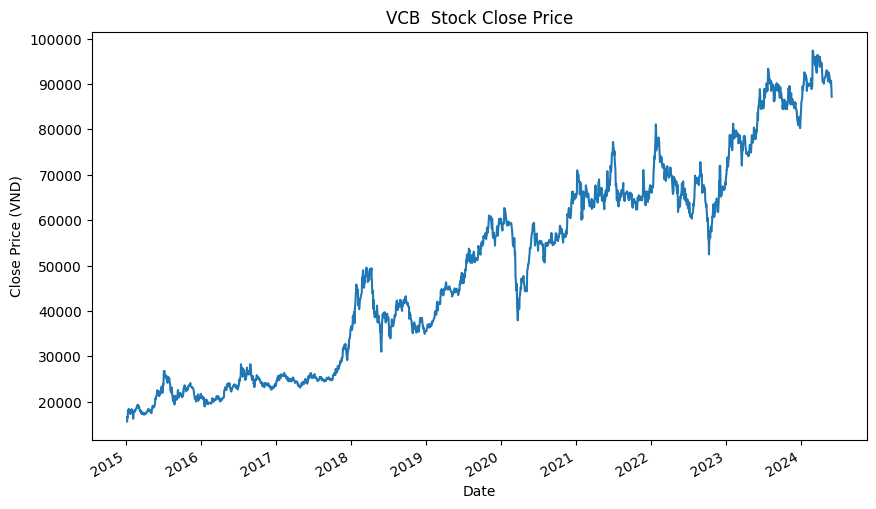

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [6]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

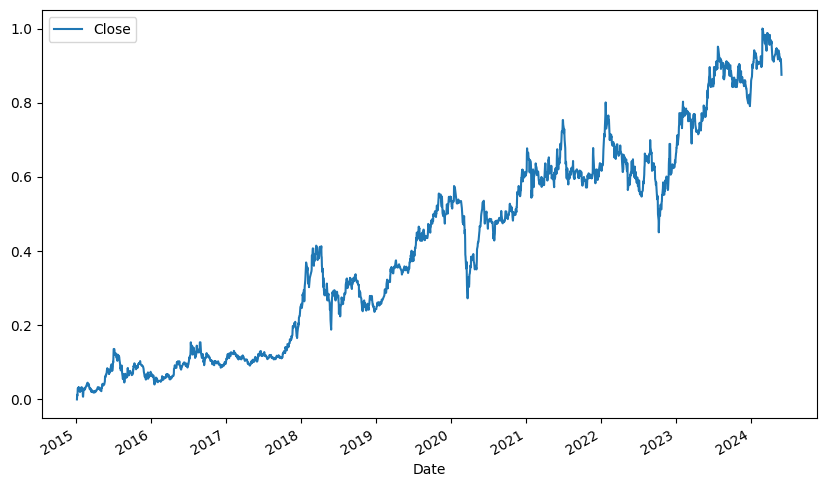

In [7]:
dataset.plot(figsize=(10, 6))

In [8]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(2105, 234)

In [9]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [10]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [11]:
time_step = 30
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [12]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2105, 30), (2105,), (234, 30), (234,))

In [14]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (2105, 30, 1), y_train Shape: (2105,)
X_test Shape: (234, 30, 1), y_test Shape: (234,)


In [16]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1202 - val_loss: 0.0032
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8966e-04 - val_loss: 0.0017
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1995e-04 - val_loss: 0.0014
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2730e-04 - val_loss: 0.0016
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7462e-04 - val_loss: 0.0011
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2342e-04 - val_loss: 6.5172e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1066e-04 - val_loss: 4.6468e-04
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5450e-04 - val_loss: 4.8913e-04
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2454e-04 - val_loss: 4.6804e-04
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3947e-04 - val_loss: 7.7211e-04
Epoch 

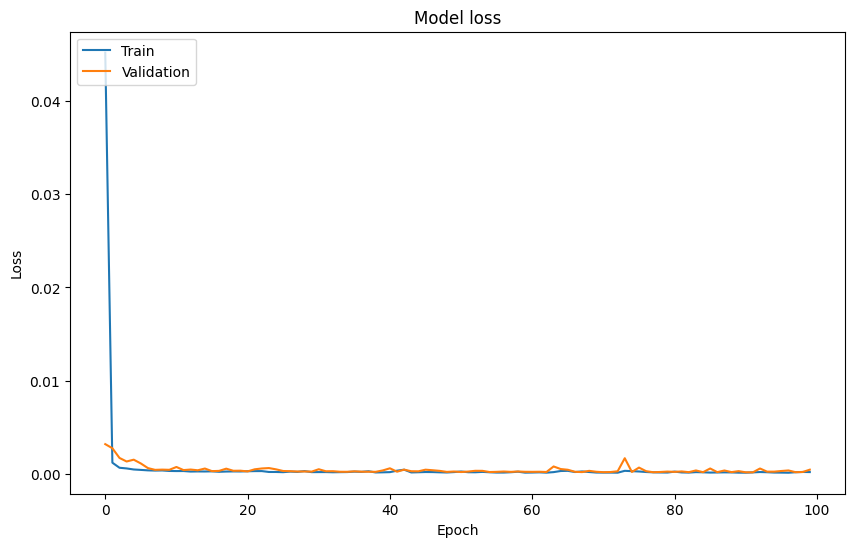

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [20]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 1318.585, Train MAE: 1076.424, Train MAPE: 2.674%
Test RMSE: 1795.919, Test MAE: 1486.549, Test MAPE: 1.66%


In [22]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [23]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [24]:
future_data

,Close
2024-06-03,86321.070312
2024-06-04,85565.742188
2024-06-05,84789.179688
2024-06-06,84238.617188
2024-06-07,83569.585938
...,...
2024-09-30,19102.228516
2024-10-01,18273.130859
2024-10-02,17441.355469
2024-10-03,16606.902344


In [25]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

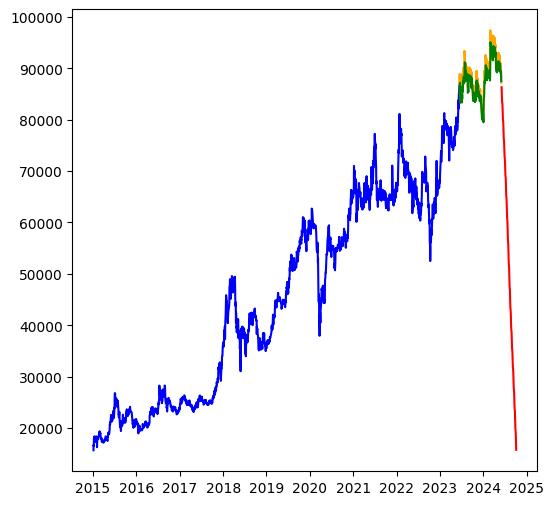

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(future_data.index, future_data['Close'], label='Predict_90days', color='red')
plt.show()

## BID

In [27]:
# Load the stock data
data_path = '../../Dataset/BID.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

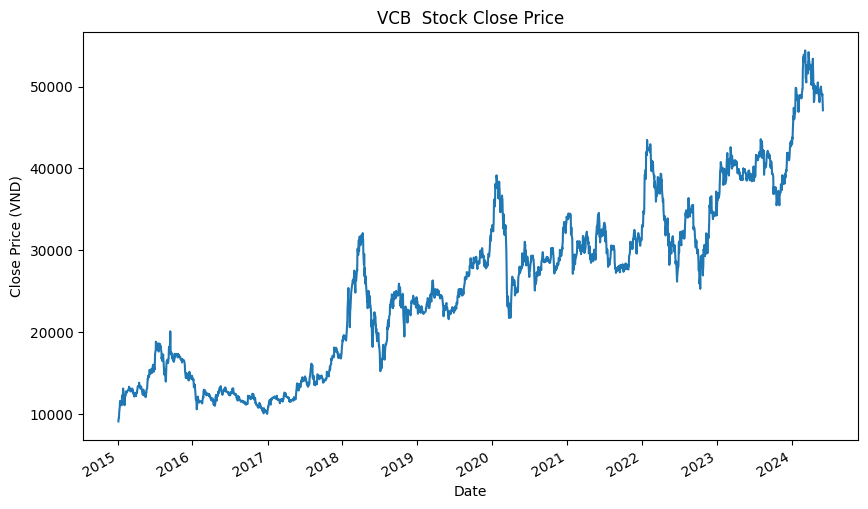

In [28]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [29]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

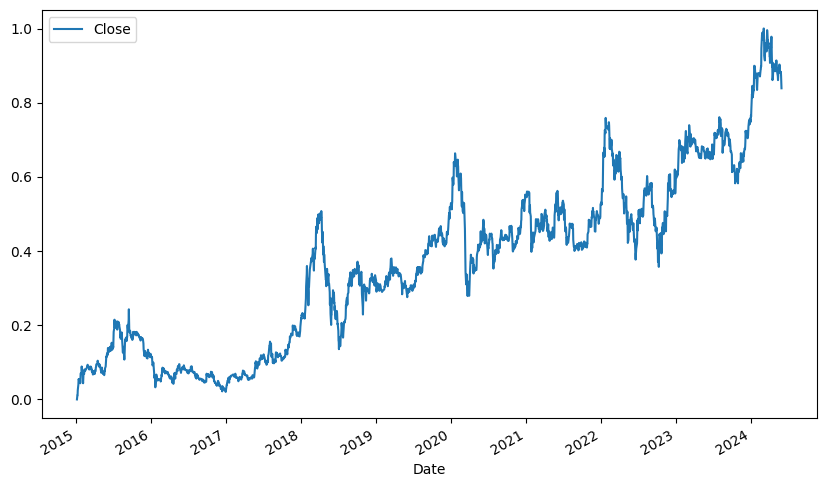

In [30]:
dataset.plot(figsize=(10, 6))

In [31]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(2110, 235)

In [32]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [33]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [34]:
time_step = 30
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [35]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2110, 30), (2110,), (235, 30), (235,))

In [37]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [38]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (2110, 30, 1), y_train Shape: (2110,)
X_test Shape: (235, 30, 1), y_test Shape: (235,)


In [39]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0550 - val_loss: 0.0062
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1797e-04 - val_loss: 0.0051
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6625e-04 - val_loss: 0.0053
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1985e-04 - val_loss: 0.0024
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5301e-04 - val_loss: 0.0028
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5772e-04 - val_loss: 0.0016
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4236e-04 - val_loss: 0.0012
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9474e-04 - val_loss: 0.0020
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8638e-04 - val_loss: 0.0016
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0083e-04 - val_loss: 8.8149e-04
Epoch 12/100
33/33 ━━━

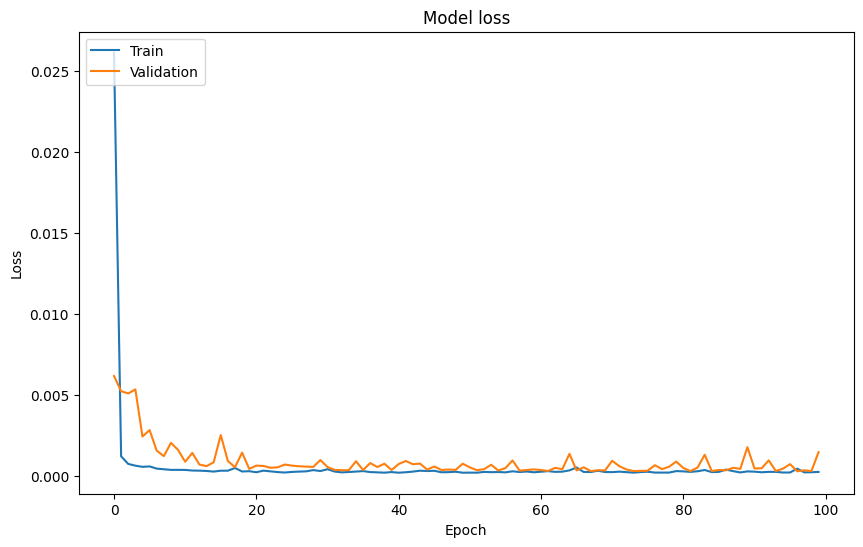

In [41]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [43]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [44]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 781.395, Train MAE: 570.969, Train MAPE: 2.33%
Test RMSE: 1739.551, Test MAE: 1559.94, Test MAPE: 3.471%


In [45]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [46]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [47]:
future_data

,Close
2024-06-03,45553.550781
2024-06-04,44182.812500
2024-06-05,42920.480469
2024-06-06,41701.363281
2024-06-07,40520.210938
...,...
2024-09-30,20677.714844
2024-10-01,20661.361328
2024-10-02,20639.486328
2024-10-03,20613.958984


In [48]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

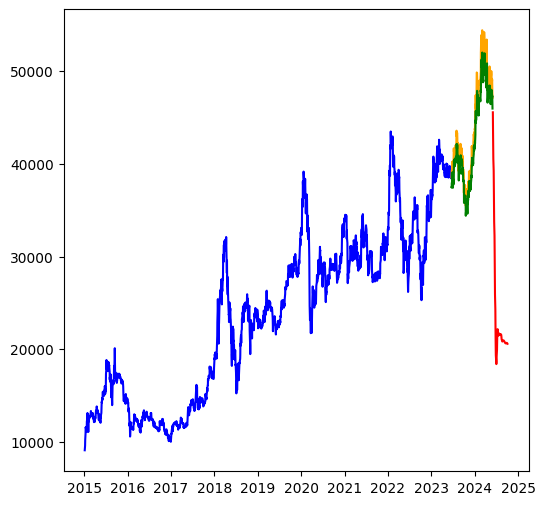

In [49]:
plt.figure(figsize=(6, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(future_data.index, future_data['Close'], label='Predict_90days', color='red')
plt.show()

## CTG

In [50]:
# Load the stock data
data_path = '../../Dataset/CTG.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

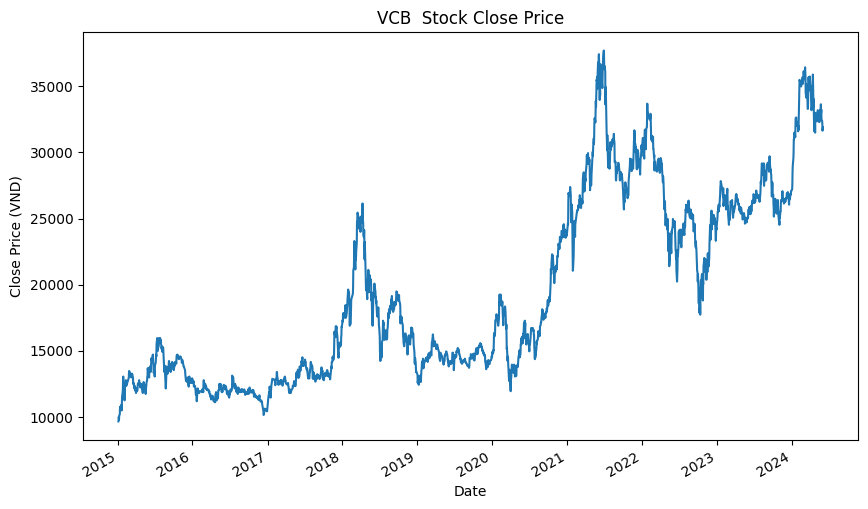

In [51]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [52]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

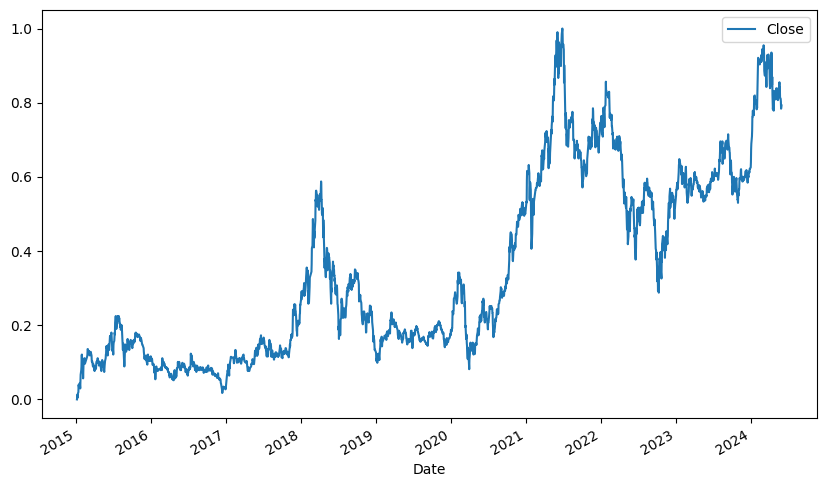

In [53]:
dataset.plot(figsize=(10, 6))

In [54]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(2110, 235)

In [55]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [56]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [57]:
time_step = 30
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [58]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2110, 30), (2110,), (235, 30), (235,))

In [60]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [61]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (2110, 30, 1), y_train Shape: (2110,)
X_test Shape: (235, 30, 1), y_test Shape: (235,)


In [62]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0471 - val_loss: 0.0023
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0228e-04 - val_loss: 0.0014
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4042e-04 - val_loss: 0.0017
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4430e-04 - val_loss: 0.0013
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8200e-04 - val_loss: 7.6937e-04
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8909e-04 - val_loss: 0.0010
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7650e-04 - val_loss: 9.0421e-04
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7140e-04 - val_loss: 6.3167e-04
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3581e-04 - val_loss: 6.3129e-04
Epoch 12/100
3

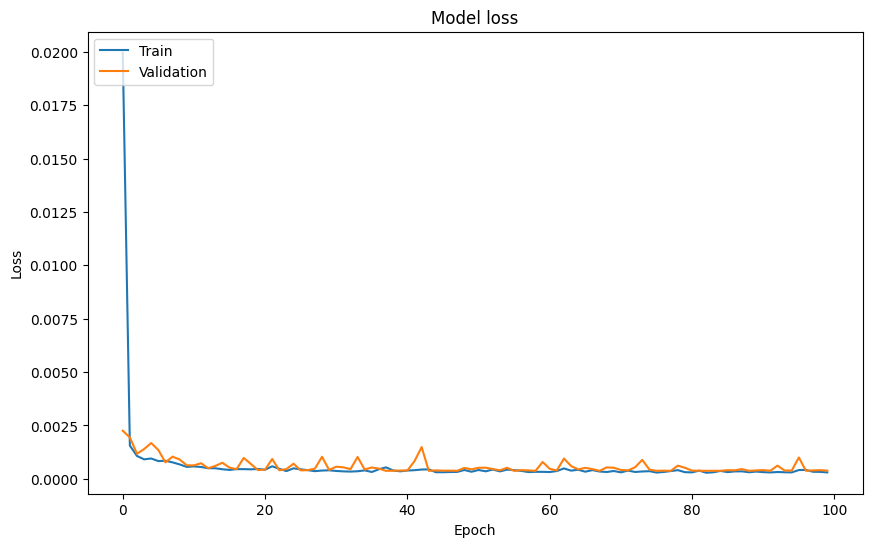

In [64]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [65]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [66]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [67]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 475.459, Train MAE: 323.966, Train MAPE: 1.792%
Test RMSE: 549.75, Test MAE: 386.015, Test MAPE: 1.275%


In [68]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [69]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [70]:
future_data

,Close
2024-06-03,31843.519531
2024-06-04,31773.667969
2024-06-05,31750.457031
2024-06-06,31678.808594
2024-06-07,31699.654297
...,...
2024-09-30,30773.759766
2024-10-01,30769.972656
2024-10-02,30766.076172
2024-10-03,30762.503906


In [71]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

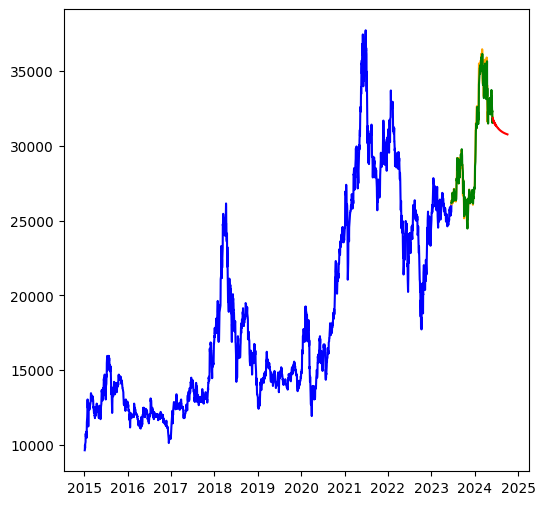

In [72]:
plt.figure(figsize=(6, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(future_data.index, future_data['Close'], label='Predict_90days', color='red')
plt.show()